# PVEc in non-native data space 

What do we do if we absolutely need to perform ASL analysis in some other space than the native acquisition space? This necessarily requires us to perform a resampling / interpolation operation, which, as we have previously demonstrated, interacts badly with the PVE already present in the raw data. This situation also encompasses voxel-wise analysis of repeat data in some common analysis space; each run needs to be transformed into said space either before or after the CBF estimation itself. 

If we start with the example of performing analysis in T1-ASL gridded space, the obvious way to obtain the PV estimates is to simply downsample the native PV estimates from the T1 image itself. Note that no transformation is required as we are transforming the ASL data into alignment with the T1, so all that remains to be done is to change the resolution of the PV estimates to match that of the ASL data. This does however lead to the paradoxical situation of having a single PV map for the analysis space, *even in the case of repeat data*. This is problematic because we know that the PVE present in each acquisition are different (if this were not the case, PVE would not cause any variability at all between runs), and yet because our analysis space is simply a linear mapping of T1 space, there is only one way to generate the PV map (downsampling). Our analysis is therefore constrained by having to assume fixed PVs for all runs, despite us knowing in advance that this is almost certainly not the case. 

The solution is to re-interpret what the role of a PV map is. The conventional understanding is that *a PV map represents the tissues that are present in each voxel*, in which case it is a function of purely of anatomy and the voxel grid in question. This is why the repeat analysis paradox arises: for a given anatomy and analysis space, there can only be one 'true' PV map. The alternative interpretation is that a PV map conveys information about how the corresponding data has been corrupted (in fact, this is the only role of a PV map with regards to PVEc). As such, it matters less that the map accurately contains the tissues that are genuinely present in each voxel, but rather that it accurately conveys what has been done to the data, *after all transformations have been applied*. To put it another way, the objective is to obtain the most accurate PV map in the native space of the acquisition (as this tells us about the mixing that ocurred at the moment the data was acquired), and then to subsequently transform that map in all the same ways as the ASL data itself: whatever you do to the data that may further corrput it, you should also do to the native space PV map. Under this interpretation, the role of the PV map is to record the interpolation artefacts that have been introduced into the ASL data, which it is better placed to do because it exists as separate signals (GM, WM) as opposed to a mixed signal (magnetisation sum of both tissues). So, in the context of a repeatability study, the pipeline would look like this: 
1. estimate the registration between the native space of each ASL acquisition and the T1 image
2. apply the reverse registration (applywarp super or Toblerone for no interpolation) to obtain PV maps in the native space of each acquisition 
3. apply the forward transform to *both* the ASL data and the PV maps to bring them into a common analysis space (T1-ASL grid) 
4. perform CBF estimation and PVEc in this space

![Experimental layout for Maastricht data](figs/pvec_double_resamp_layout.png)

In pratice, what we have done to the PV maps is a round-trip: into native ASL space and then back into T1 aligned space (T1-ASL grid), so I'm calling it a *double-resampled* map. If our data was of infinite resolution, then there wouldn't be any difference between the double-resampled map and the original T1 map. In reality the maps are in fact quite different in all the important places, and this difference confirms the fact that interpolation on finite resolution data is indeed having a measurable effect. Crucially, it is assumed that it's the second step that does the damage: the T1 -> ASL step is from high to low resolution, so subvoxel effects and interpolation artefacts are minimised, whereas the ASL -> T1-ASL step is from low to low resolution, in which case subvoxel effects do play an important role (the Toblerone paper discusses the importance of ratio in voxel size on subvoxel effects). 


Simulations of this repeatability setup are performed using an HCP subject, for which the T1 resolution is 0.7mm isotropic and ASL is 3mm iso. We assume for the sake of argument that the resolution of the T1 is sufficiently high that we can resample it to other spaces without significant loss of data quality; in the ideal case we can actually run Toblerone afresh in each new space to obtain PVs with minimal resampling (for the surfaces anyway). 

In [1]:
import regtricks as rt 
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from pdb import set_trace
from scipy.spatial.transform import Rotation
from pvec_functions import *
np.random.seed(1)

Assume constant CBF in both GM and WM of 60,20 respectively. 

In [2]:
GM_CBF, WM_CBF = 60, 20
make_mask = lambda a: (a[...,:2] > 0.02).all(-1)
bin_edges = np.arange(11.5,71.5,1)
def get_fig(size=(15,5), dpi=100, **kwargs): 
    return plt.figure(figsize=size, dpi=dpi, **kwargs)

The T1 PV map at 0.7mm is taken to be ground truth, from which CBF maps are simulated. The common analysis space is at 3mm and aligned with the T1, ie, T1-ASL grid. 

In [3]:
asl_spc = rt.ImageSpace('tob_all_stacked_3.0.nii.gz')
t1_spc = rt.ImageSpace('tob_all_stacked_0.7.nii.gz')
pvs_native = nibabel.load('tob_all_stacked_3.0.nii.gz').get_fdata()
pvs_high = nibabel.load('tob_all_stacked_0.7.nii.gz').get_fdata()
mid_slice = asl_spc.size[-1] // 2
mid_slice_high = t1_spc.size[-1] // 2
native_mask = make_mask(pvs_native)

Generate 4 random transformations: rotation in the xy plane and a translation in xy. 

In [4]:
transforms = []
RPTS = 4
for _ in range(RPTS):
    rot = Rotation.from_euler('z', np.random.randint(0,11), degrees=True)
    transform = np.eye(4)
    transform[:3,:3] = rot.as_matrix() 
    transform[:2,3] = 10 * (np.random.rand(2))
    transform = rt.Registration(transform)
    transforms.append(transform)

For each transform: 
1. apply the transform to the ground truth PV map and downsample to ASL resolution (using supersampling) 
2. generate a CBF map from this native space transformed PV map 
3. apply the inverse transform to both the native space PV map and CBF image to bring them back into alignment with T1, at ASL resolution (T1-ASL grid)

In [5]:
cbf_repeats_raw = []
cbf_repeats_common = []
pv_repeats_raw = []
pv_repeats_common = []
mask_repeats_raw = []
mask_repeats_common = []
for trans in transforms: 
    pv_raw = trans.apply_to_array(pvs_high, t1_spc, asl_spc)
    cbf_raw = (GM_CBF * pv_raw[...,0]) + (WM_CBF * pv_raw[...,1])
    cbf_common = trans.inverse().apply_to_array(cbf_raw, asl_spc, asl_spc, order=1)
    pv_common = trans.inverse().apply_to_array(pv_raw, asl_spc, asl_spc, order=1)
    
    mask_repeats_raw.append(make_mask(pv_raw))
    mask_repeats_common.append(make_mask(pv_common))
    pv_repeats_raw.append(pv_raw)
    pv_repeats_common.append(pv_common)
    cbf_repeats_raw.append(cbf_raw)
    cbf_repeats_common.append(cbf_common)

Top row: CBF maps in native transformed space 

Bottom row: CBF maps in common aligned space. 

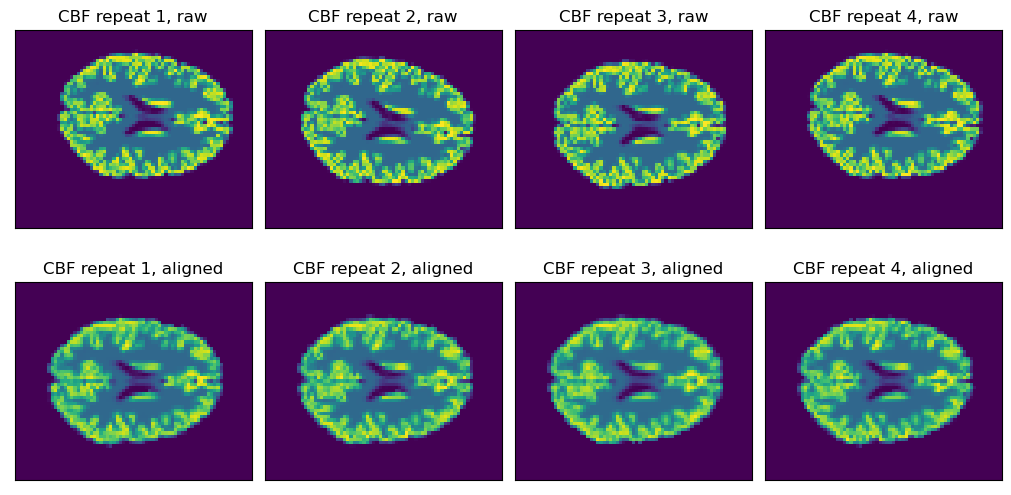

In [6]:
fig = get_fig(size=(10,5), constrained_layout=True)
for r in range(RPTS):
    plt.subplot(2,RPTS,r+1)
    plt.imshow(cbf_repeats_raw[r][:,:,mid_slice])
    plt.xticks([]); plt.yticks([])
    plt.title(f'CBF repeat {r+1}, raw')
    plt.subplot(2,RPTS,r+RPTS+1)
    plt.imshow(cbf_repeats_common[r][:,:,mid_slice])
    plt.title(f'CBF repeat {r+1}, aligned')
    plt.xticks([]); plt.yticks([])

## **The super important bit**

Top row: differences between ground truth GM PV map in common aligned space, and the double-resampled PV map corresponding to each CBF repeat. Note that difference voxels tend to be positive, which corresponds to negative bias on the double resampled map. Ie, as expected, the double resampled map has fewer pure GM voxels, hence the difference wrt ground truth is positive-biased. 

Bottom row: histogram of differences for the image in the top row. 

These double-transformed maps are meant to be the same as the ground truth; after all, we've just done a round trip of transformations. As can clearly be seen, they are definitely not the same, and the individual voxel-wise differences can be enormous (~30% absolute PV difference). It stands to reason that the accompanying ASL data has also undergone a corresponding amount of mixing, because the interpolation process depends purely on the respective voxel grids and not on the nature of the signal itself. 

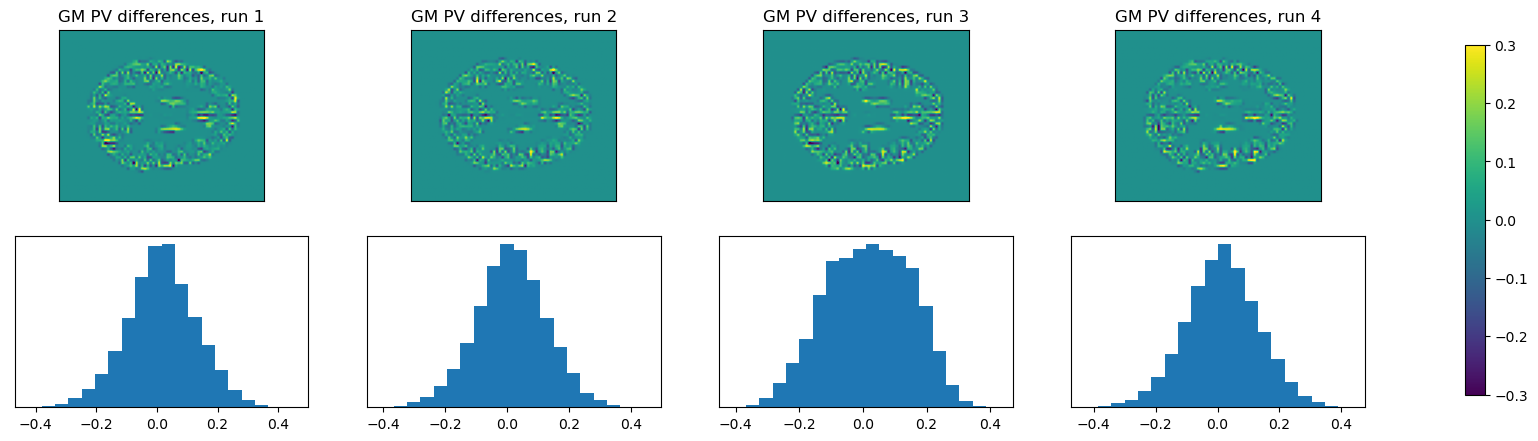

In [7]:
fig = get_fig(size=(20,5))
for r in range(RPTS):
    plt.subplot(2,RPTS,r+1)
    gm_diff = pvs_native[...,0] - pv_repeats_common[r][...,0] 
    im = plt.imshow(gm_diff[...,mid_slice], vmin=-0.3, vmax=0.3)
    plt.xticks([]); plt.yticks([])
    plt.title(f'GM PV differences, run {r+1}')
    plt.subplot(2,RPTS,r+RPTS+1)
    plt.hist(gm_diff[native_mask], 20)
    plt.yticks([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In response to Flora's question, how well is overall tissue volume preserved following the double-resampling? Particularly around sharp edges, a small amount of tissue may go missing, in which case it is possible to re-scale the per-voxel PVs so that they sum back to unity (not that the distribution between tissues is preserved for this approach). As can be seen, a small amount of tissue does indeed go missing from some voxels, on the order of 1-2%. 

In the below analysis, I've performed PVEc with both the original double-resampled PV maps, and with rescaling applied. 

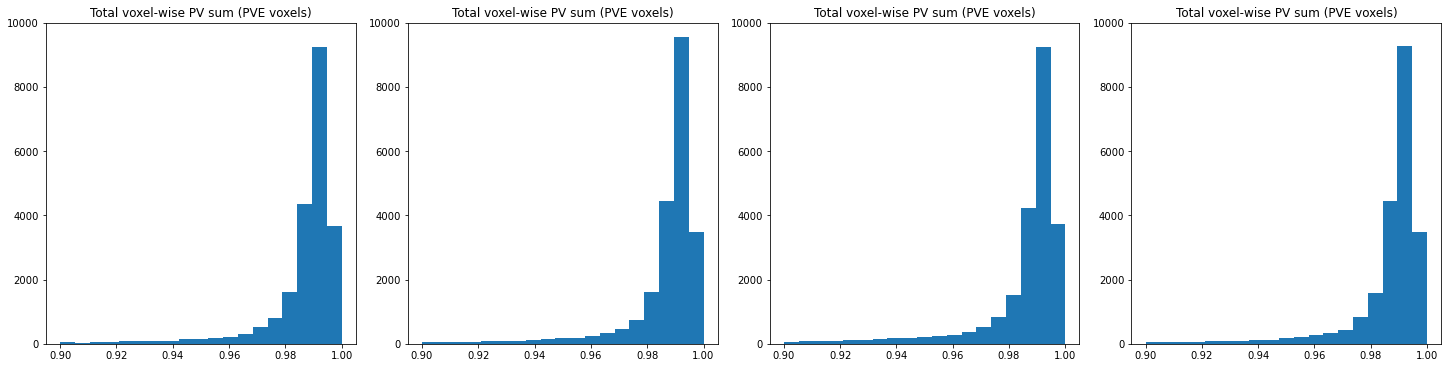

In [8]:
fig, axes = plt.subplots(1, RPTS, constrained_layout=True)
fig.set_size_inches(20,5)
sum_bins = np.linspace(0.9,1,20)
for r in range(RPTS):
    ax = axes[r]
    mask = mask_repeats_common[r]
    pvs = pv_repeats_common[r]
    sums = pvs[mask,:].sum(1)
    ax.hist(sums, sum_bins)
    ax.set_ylim(0,1e4)
    ax.set_title(f'Total voxel-wise PV sum (PVE voxels)')

Perform PVEc on each common-aligned CBF map, using both the ground truth PV estimates (ie, the paradoxical situation of using a single map for all acquisitions), and using the double-resampled map that is specific to each. 

In [9]:
cbf_pvec_common_naive = []
cbf_pvec_common_double = []
cbf_pvec_common_double_rescaled = []
for rpt in range(RPTS):
    cbf_pvec_common_naive.append(pvec_lr(cbf_repeats_common[rpt], pvs_native, native_mask, mid_slice))
    
    pv_common = pv_repeats_common[rpt]
    cbf_pvec_common_double.append(pvec_lr(cbf_repeats_common[rpt], pv_common, 
                                   mask_repeats_common[rpt], mid_slice))
    
    
    pv_rescaled = rescale_pvs(pv_common)
    cbf_pvec_common_double_rescaled.append(pvec_lr(cbf_repeats_common[rpt], pv_rescaled, 
                                   mask_repeats_common[rpt], mid_slice))

Top row: CBF within PVE voxels before PVEc, native space, in which two vague peaks at 20 and 60 can be observed 

Second row: CBF within PVE voxels before PVEc, common aligned space, in which the two peaks can no longer be observed due to the mixing introduced by the resampling step

Third row: CBF after PVEc with the ground truth map that is common to all runs (ie, the paradox case), which performs very badly 

Fourth row: CBF after PVEc with the double-resampled map that is specific to each run, which performs much better

Final row: CBF after PVEc with the double-resampled and rescaled map, which performs marginally worse than the row above. 

The results of PVEc with double-resampling and rescaling might seem surprising: we know that total tissue volume should be preserved during a transformation, so it seems logical to rescale to enforce this. However, referring back to an earlier point about the role of a PV map: it should convey, as faithfully as possible, that which has been done to the ASL data. If you rescale the PV map, you violate this principle, as no such operation has been done to the ASL data (although, it is reasonable to ask the question of whether we should - has signal gone missing there?). So, although this result doesn't make sense from an anatomy point of view, it does make sense from a mathemetical / signal processing point of view, and ultimately the operation of PVEc belongs to the latter domain, not the former. 

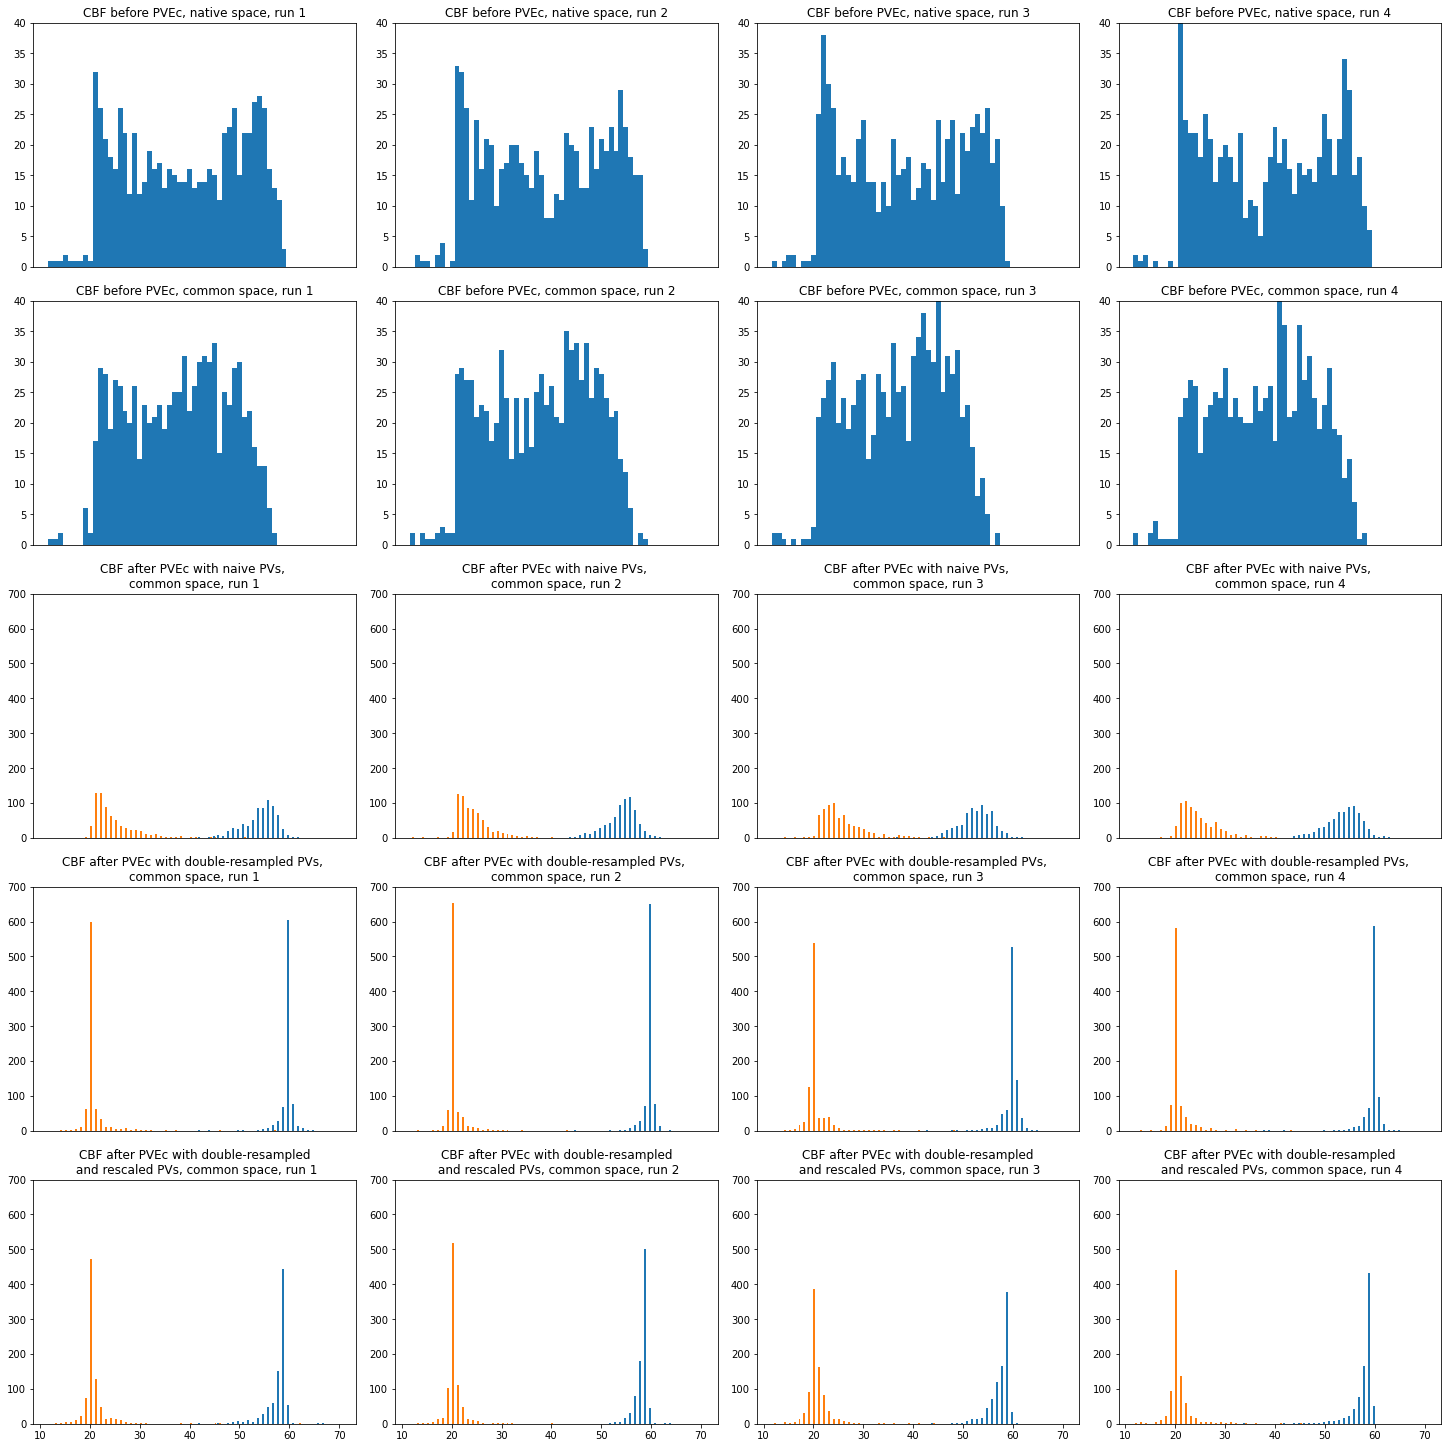

In [10]:
fig, axes = plt.subplots(5, RPTS, constrained_layout=True)
fig.set_size_inches(20,20)
before_lim = (0,40)
after_lim = (0,700) 
for r in range(RPTS):
    ax = axes[0,r]
    mask = mask_repeats_raw[r][...,mid_slice]
    raw = cbf_repeats_raw[r][...,mid_slice]
    ax.hist(raw[mask], bin_edges)
    ax.set_ylim(before_lim); ax.set_xticks([])
    ax.set_title(f'CBF before PVEc, native space, run {r+1}')
    
    ax = axes[1,r]
    mask = mask_repeats_common[r][...,mid_slice]
    raw = cbf_repeats_common[r][...,mid_slice]
    ax.hist(raw[mask], bin_edges)
    ax.set_ylim(before_lim); ax.set_xticks([])
    ax.set_title(f'CBF before PVEc, common space, run {r+1}')

    ax = axes[2,r]
    ax.hist(cbf_pvec_common_naive[r], bin_edges)
    ax.set_ylim(after_lim); ax.set_xticks([])
    ax.set_title(f'CBF after PVEc with naive PVs, \ncommon space, run {r+1}')
    
    ax = axes[3,r]
    ax.hist(cbf_pvec_common_double[r], bin_edges)
    ax.set_title(f'CBF after PVEc with double-resampled PVs, \ncommon space, run {r+1}')
    ax.set_ylim(after_lim); ax.set_xticks([])
    
    ax = axes[4,r]
    ax.hist(cbf_pvec_common_double_rescaled[r], bin_edges)
    ax.set_title(f'CBF after PVEc with double-resampled\n and rescaled PVs, common space, run {r+1}')
    ax.set_ylim(after_lim);


## With variable CBF  

Same setup as before, but this time ground truth CBF values are drawn from normal distributions with SD as defined below. 

In [11]:
GM_SD, WM_SD = 8, 3 

In [12]:
cbf_repeats_raw_var = []
cbf_repeats_common_var = []
wm_repeats_truth = []
gm_repeats_truth = []

for rpt in range(RPTS):
    trans = transforms[rpt]
    pv_raw = pv_repeats_raw[rpt]
    gm_cbf = np.random.normal(GM_CBF, GM_SD, asl_spc.size)
    wm_cbf = np.random.normal(WM_CBF, WM_SD, asl_spc.size)
    cbf_raw = ((gm_cbf * pv_raw[...,0]) + (wm_cbf * pv_raw[...,1]))
    cbf_common = trans.inverse().apply_to_array(cbf_raw, asl_spc, asl_spc, order=1)
    
    cbf_repeats_raw_var.append(cbf_raw)
    cbf_repeats_common_var.append(cbf_common)
    wm_repeats_truth.append(wm_cbf)
    gm_repeats_truth.append(gm_cbf)

In [13]:
cbf_pvec_common_naive_var = []
cbf_pvec_common_double_var = []
for rpt in range(RPTS):
    cbf_pvec_common_naive_var.append(pvec_lr(cbf_repeats_common_var[rpt], pvs, native_mask, mid_slice))
    cbf_pvec_common_double_var.append(pvec_lr(cbf_repeats_common_var[rpt], pv_repeats_common[rpt], 
                                      mask_repeats_common[rpt], mid_slice))


Top row: CBF within PVE voxels before PVEc, native space, in which two vague peaks at 20 and 60 can be observed 

Second row: CBF within PVE voxels before PVEc, common aligned space, in which the two peaks can no longer be observed due to the mixing introduced by the resampling step

Third row: CBF after PVEc with the ground truth map that is common to all runs (ie, the paradox case), which performs very badly 

Final row: CBF after PVEc with the double-resampled map that is specific to each run, which performs much better. 

The improvement in performance isn't as pronounced in this case, and is especially hard to measure given that there's no single ground truth. Or rather, there is a ground truth GM / WM CBF map that we generated for each acquisition in native space, but PVEc is performed in a difference space, and so we have no means of matching voxels in either space to each other without resorting to interpolation... Nevertheless, there is a 'peak sharpening' effect on the histogram when using double-resampled maps, so even in the presence of underlying phsiological variability, it seems reasonable to conclude that the double-resampled map facilitates improved PVEc, as measured by better GM / WM signal separation. 

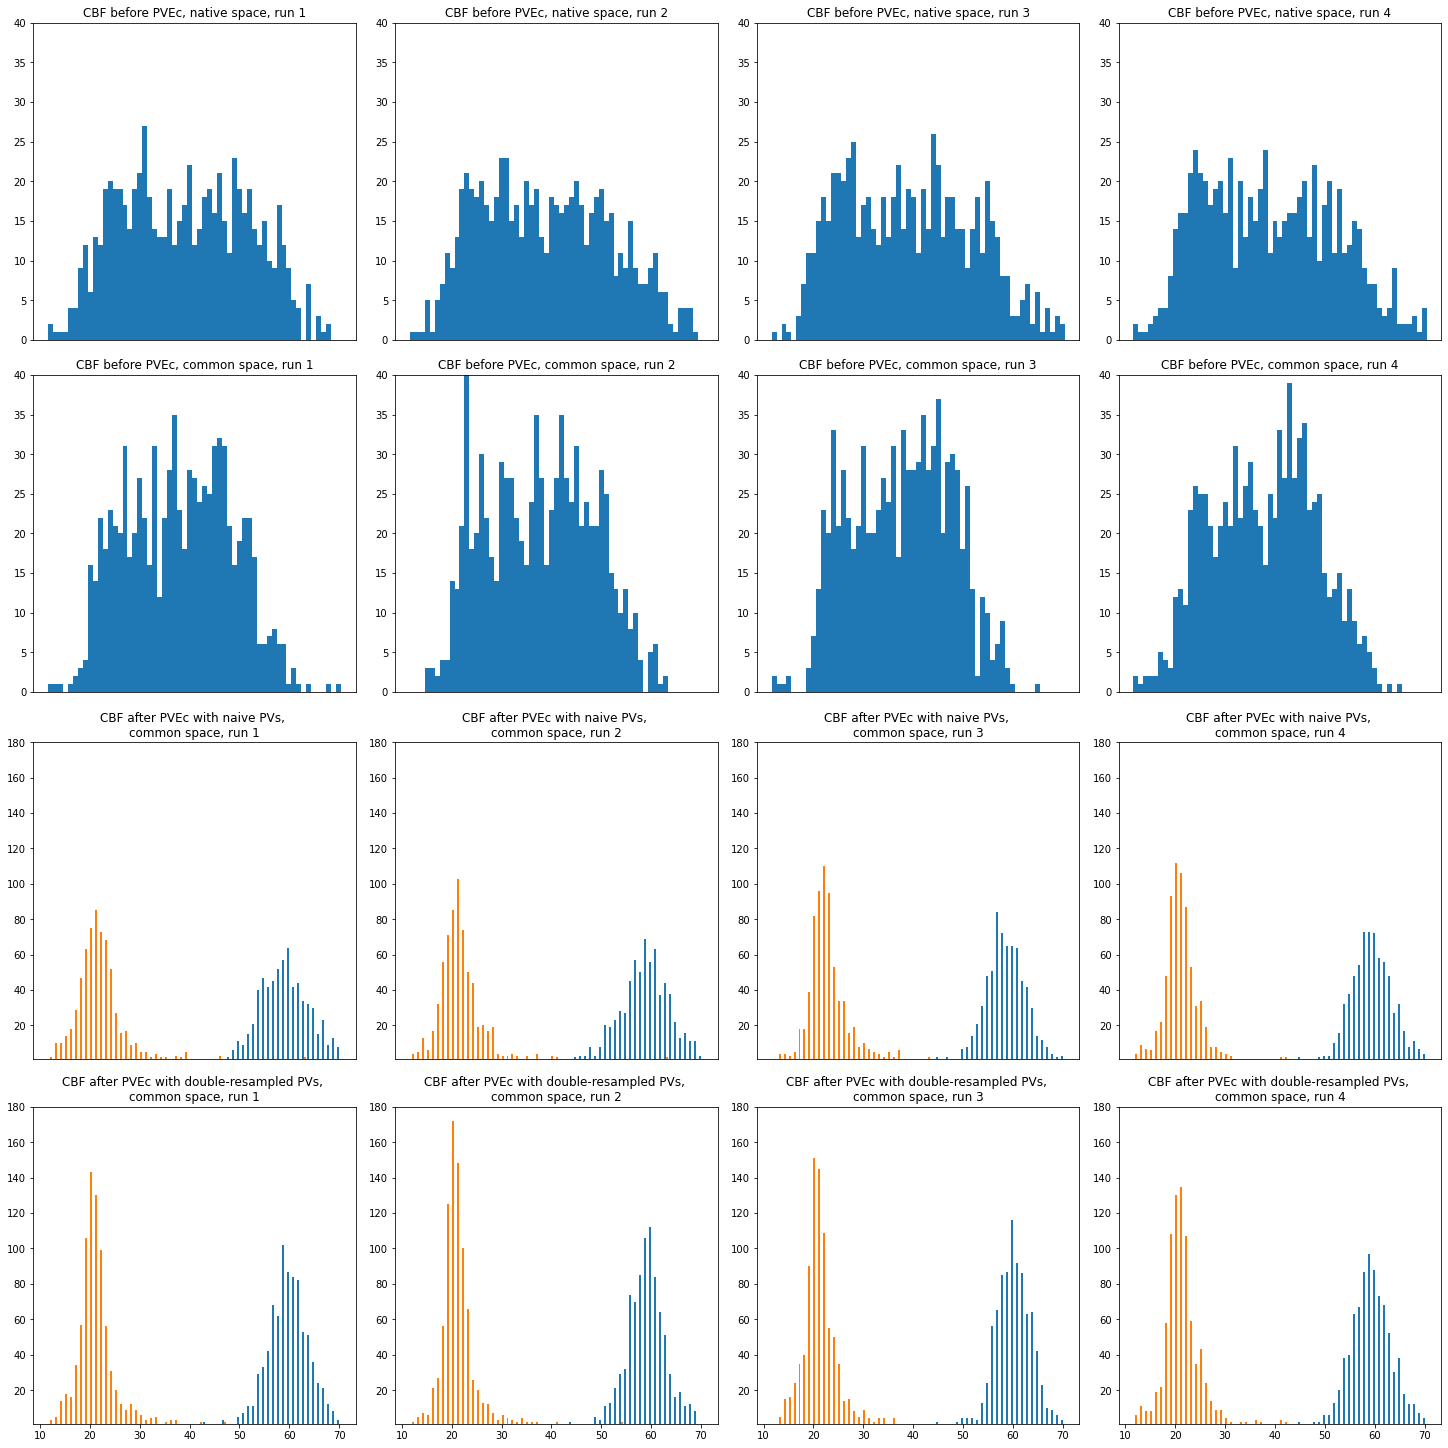

In [14]:
fig, axes = plt.subplots(4, RPTS, constrained_layout=True)
fig.set_size_inches(20,20)
before_lim = (0,40)
after_lim = (1,180)
for r in range(RPTS):
    ax = axes[0,r]
    mask = mask_repeats_raw[r][...,mid_slice]
    raw = cbf_repeats_raw_var[r][...,mid_slice]
    ax.hist(raw[mask], bin_edges)
    ax.set_xticks([]); ax.set_ylim(before_lim)
    ax.set_title(f'CBF before PVEc, native space, run {r+1}')
    
    ax = axes[1,r]
    mask = mask_repeats_common[r][...,mid_slice]
    raw = cbf_repeats_common_var[r][...,mid_slice]
    ax.hist(raw[mask], bin_edges)
    ax.set_xticks([]); ax.set_ylim(before_lim)
    ax.set_title(f'CBF before PVEc, common space, run {r+1}')

    ax = axes[2,r]
    ax.hist(cbf_pvec_common_naive_var[r], bin_edges)
    ax.set_xticks([]); ax.set_ylim(after_lim)
    ax.set_title(f'CBF after PVEc with naive PVs, \ncommon space, run {r+1}')
    
    ax = axes[3,r]
    ax.hist(cbf_pvec_common_double_var[r], bin_edges)
    ax.set_title(f'CBF after PVEc with double-resampled PVs, \ncommon space, run {r+1}')
    ax.set_ylim(after_lim);